# Задание 1

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.patches
from sklearn.linear_model import LinearRegression
from matplotlib import rcParams
plot_w = 13
plot_h = 7
rcParams['figure.figsize'] = plot_w, plot_h
davis_df = pd.read_csv("datasets/Davis.csv")

In [2]:
davis_df

,Unnamed: 0,sex,weight,height,repwt,repht
0,1,M,77,182,77.0,180.0
1,2,F,58,161,51.0,159.0
2,3,F,53,161,54.0,158.0
3,4,M,68,177,70.0,175.0
4,5,F,59,157,59.0,155.0
...,...,...,...,...,...,...
195,196,M,74,175,71.0,175.0
196,197,M,83,180,80.0,180.0
197,198,M,81,175,NaN,NaN
198,199,M,90,181,91.0,178.0


## Вычисление пропорции мужчин в выборке

In [3]:
def male_proportion(df):
    df.groupby([df.sex == "M"]).count()
    M_count = len(df[df.sex == "M"].index)
    return M_count / len(df.index)
male_proportion(davis_df)

0.44

## Выявление аномалий

Text(0, 0.5, 'weight')

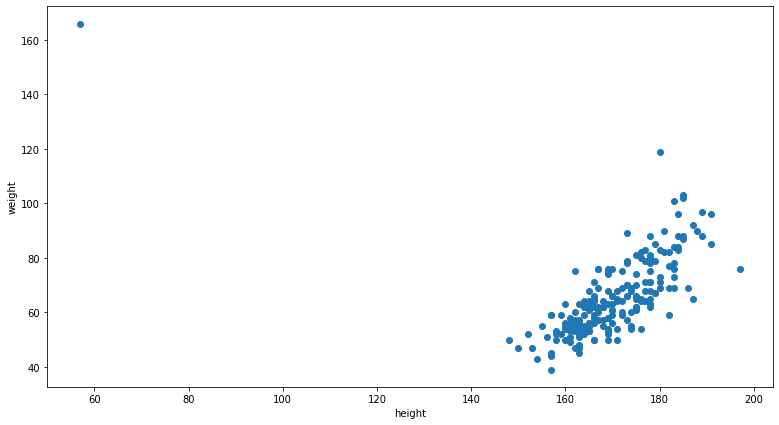

In [4]:
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

Text(0, 0.5, 'repwt')

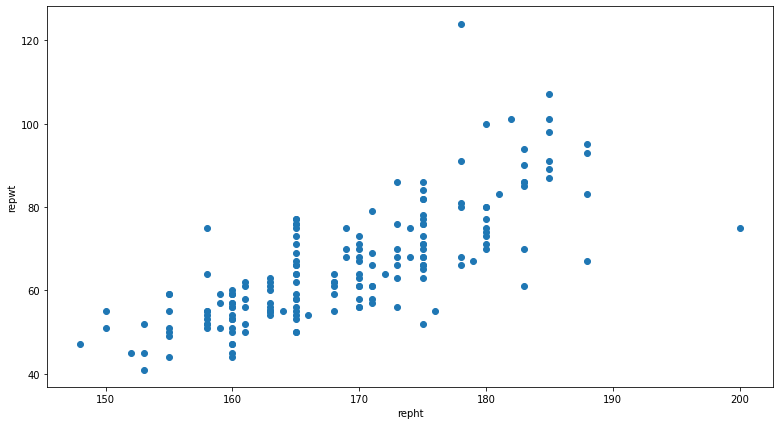

In [5]:
plt.scatter(x=davis_df["repht"], y=davis_df["repwt"])
plt.xlabel("repht")
plt.ylabel("repwt")

Text(0, 0.5, 'weight')

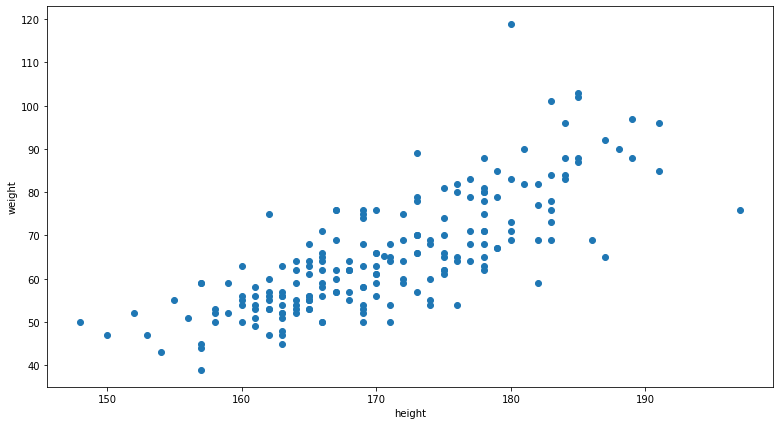

In [6]:
davis_df.where(davis_df["height"] > 100, inplace=True)
davis_df.fillna(davis_df.mean(), inplace=True)
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

## Разбиение выборки на 2 с сохранением пропорции:

In [7]:
male_proportion(davis_df)

0.44

In [8]:
male_davis_df = davis_df[davis_df.sex == "M"]
female_davis_df = davis_df[davis_df.sex == "F"]
train_davis_df = male_davis_df.sample(frac=0.5).append(female_davis_df.sample(frac=0.5))
test_davis_df = pd.concat([davis_df, train_davis_df]).drop_duplicates(keep=False)
male_proportion(train_davis_df), male_proportion(test_davis_df)

(0.44, 0.44)

## Отображение train-выборки на в виде точек на графике

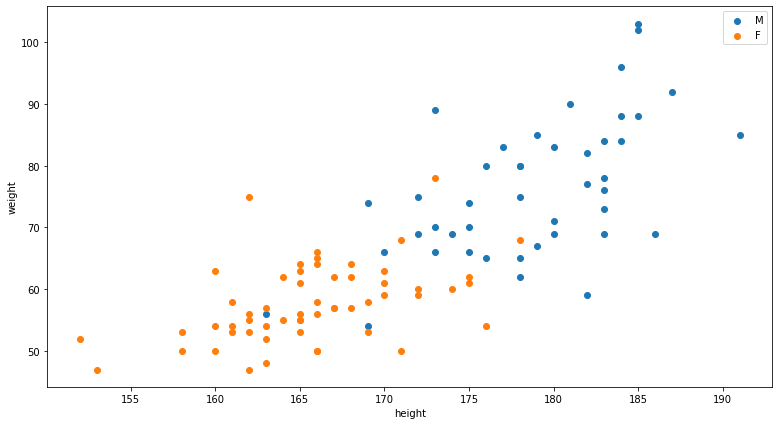

In [9]:
plt.scatter(x=train_davis_df.where(train_davis_df["sex"] == "M")["height"],
            y=train_davis_df.where(train_davis_df["sex"] == "M")["weight"], label="M")
plt.scatter(x=train_davis_df.where(train_davis_df["sex"] == "F")["height"],
            y=train_davis_df.where(train_davis_df["sex"] == "F")["weight"], label="F")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

## Построение гистограмм роста и веса

### Общая

Text(0.5, 0, 'weight')

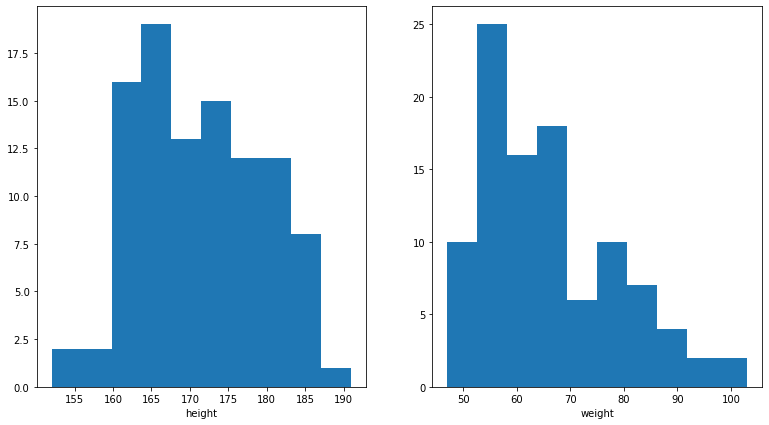

In [10]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df["weight"])
ax[1].set_xlabel("weight")

### Только мужчины

Text(0.5, 0, 'weight')

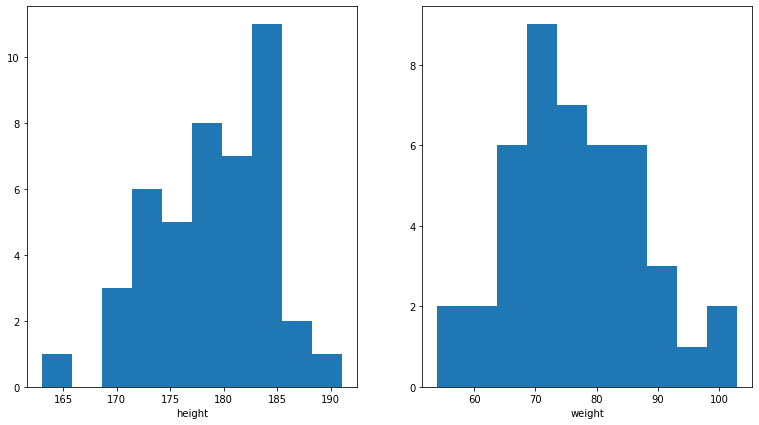

In [11]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[1].set_xlabel("weight")

### Только женщины

Text(0.5, 0, 'weight')

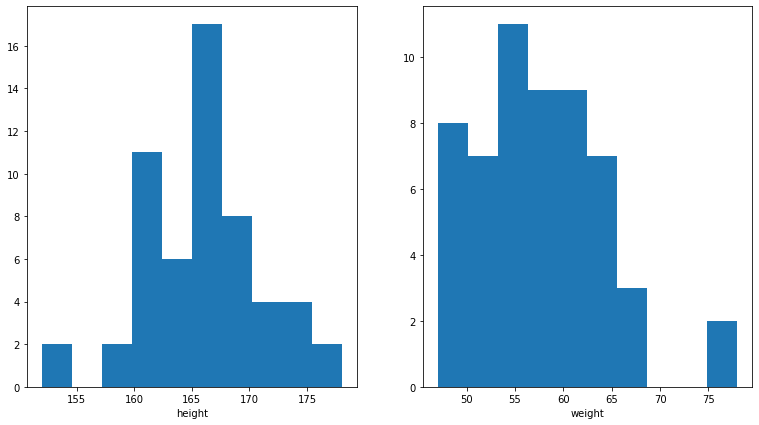

In [12]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[1].set_xlabel("weight")

## Построение гистограмм величин (repwt - weight) и (repht - height)

### Общая

Text(0.5, 0, 'repht - height')

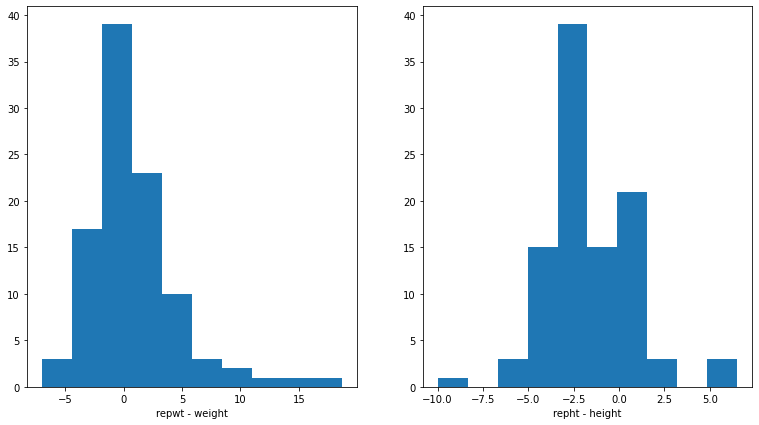

In [13]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["repwt"] - train_davis_df["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df["repht"] - train_davis_df["height"])
ax[1].set_xlabel("repht - height")

### Только мужчины

Text(0.5, 0, 'repht - height')

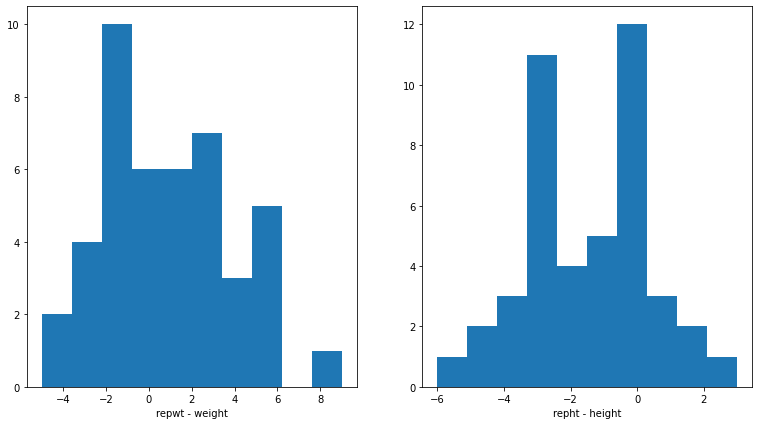

In [14]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repht"] - train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[1].set_xlabel("repht - height")

### Только женщины

Text(0.5, 0, 'repht - height')

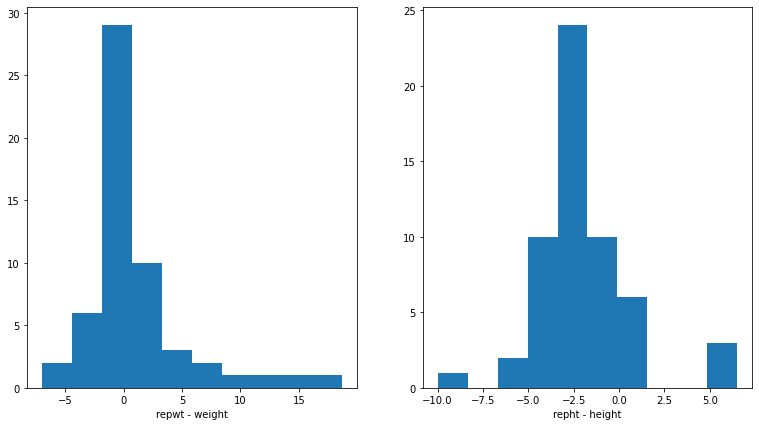

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repht"] - train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[1].set_xlabel("repht - height")

## Построение генератора

In [108]:
class DataGenerator:
    def __init__(self):
        self.p_woman = None
        self.p_man = None
        self.mean_height = { "woman": None, "man": None }
        self.mean_weight = { "woman": None, "man": None }
        self.cov_matrix = { "woman": None, "man": None }
         
        
    def fit(self, df):
        self.p_man = male_proportion(df) 
        self.p_woman = 1 - self.p_man
        self.mean_height["woman"] = np.mean(df.where(df["sex"] == "F")["height"])
        self.mean_height["man"] = np.mean(df.where(df["sex"] == "M")["height"])
        self.mean_weight["woman"] = np.mean(df.where(df["sex"] == "F")["weight"])
        self.mean_weight["man"] = np.mean(df.where(df["sex"] == "M")["weight"])
        self.cov_matrix["woman"] = np.cov(df[df["sex"] == "F"]["height"].to_numpy(),
                                          df[df["sex"] == "F"]["weight"].to_numpy())
        self.cov_matrix["man"] = np.cov(df[df["sex"] == "M"]["height"].to_numpy(),
                                        df[df["sex"] == "M"]["weight"].to_numpy())
        return self
    
    
    def generate_points(self, n_points):
        result = []
        for i in range(n_points):
            sex = scipy.stats.distributions.bernoulli.rvs(self.p_woman)
            if(sex == 0):
                hw = np.random.multivariate_normal(mean=[self.mean_height["man"], self.mean_weight["man"]],
                                                   cov=self.cov_matrix["man"], size=1)
                result.append(np.array([sex, hw[:, 0][0], hw[:, 1][0]]))
            else:
                hw = np.random.multivariate_normal(mean=[self.mean_height["woman"], self.mean_weight["woman"]],
                                                   cov=self.cov_matrix["woman"], size=1)
                result.append(np.array([sex, hw[:, 0][0], hw[:, 1][0]]))
        return np.array(result, dtype=float)
    
    
    def log_likehood(self, df):
        x_man = df[df["sex"] == "M"][["height", "weight"]].values
        x_woman = df[df["sex"] == "F"][["height", "weight"]].values
        
    
        result_man = self.p_man * scipy.stats.multivariate_normal.pdf(x=x_man, mean=[self.mean_height["man"], 
                                                                        self.mean_weight["man"]],
                                                                        cov=self.cov_matrix["man"])
        result_woman = self.p_woman * scipy.stats.multivariate_normal.pdf(x=x_woman, mean=[self.mean_height["woman"],
                                                                            self.mean_weight["woman"]],
                                                                            cov=self.cov_matrix["woman"])
        return np.log(np.concatenate((result_man, result_woman), axis=None))
    
    
    def mean_log_likehood(self, df):
        return self.log_likehood(df).sum() / len(df.index)

In [109]:
generator = DataGenerator()
generator.fit(train_davis_df)
generated_data = generator.generate_points(100)
generated_data

array([[  0.        , 186.90557517,  81.75162439],
       [  0.        , 184.56755932,  74.92411457],
       [  0.        , 171.51360536,  68.6154125 ],
       [  1.        , 166.58473338,  59.15702719],
       [  0.        , 173.14052335,  72.61316989],
       [  1.        , 165.08450767,  56.11407582],
       [  1.        , 169.11492301,  64.50989895],
       [  0.        , 177.66156119,  73.85294413],
       [  0.        , 179.99936531,  80.8745213 ],
       [  0.        , 183.06112368,  72.3129593 ],
       [  0.        , 181.18690751,  89.24678201],
       [  1.        , 168.6401602 ,  50.71100392],
       [  1.        , 163.58269509,  56.33451859],
       [  1.        , 164.13314683,  61.85458451],
       [  1.        , 168.37418751,  55.55176625],
       [  1.        , 166.46557633,  59.61749277],
       [  0.        , 191.55991231,  96.44480447],
       [  1.        , 172.01325886,  66.39564457],
       [  0.        , 172.94443816,  55.47304024],
       [  0.        , 176.79209

In [113]:
generated_df = pd.DataFrame( {"sex" : generated_data.T[0], "height" : generated_data.T[1], "weight" : generated_data.T[2]})
generated_df["sex"][generated_df["sex"] == 1] = "F"
generated_df["sex"][generated_df["sex"] == 0] = "M"
generated_df

,sex,height,weight
0,M,186.905575,81.751624
1,M,184.567559,74.924115
2,M,171.513605,68.615412
3,F,166.584733,59.157027
4,M,173.140523,72.613170
...,...,...,...
95,M,186.267068,82.644253
96,F,165.813218,58.397588
97,F,169.497733,56.520233
98,F,164.144145,54.640599


In [114]:
generator.mean_log_likehood(train_davis_df)

-7.148039669971296

In [115]:
generator.mean_log_likehood(test_davis_df)

-7.478366940565494

In [116]:
generator.mean_log_likehood(generated_df)

-7.089518479821842

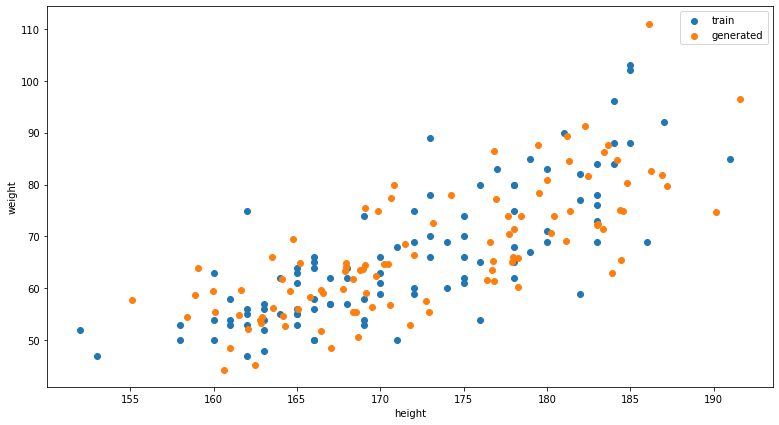

In [117]:
plt.scatter(x=train_davis_df["height"], y=train_davis_df["weight"], label="train")
plt.scatter(x=generated_data.T[1], y=generated_data.T[2], label="generated")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

[150.0, 200.0, 40.0, 120.0, 150.0, 200.0, 40.0, 120.0]

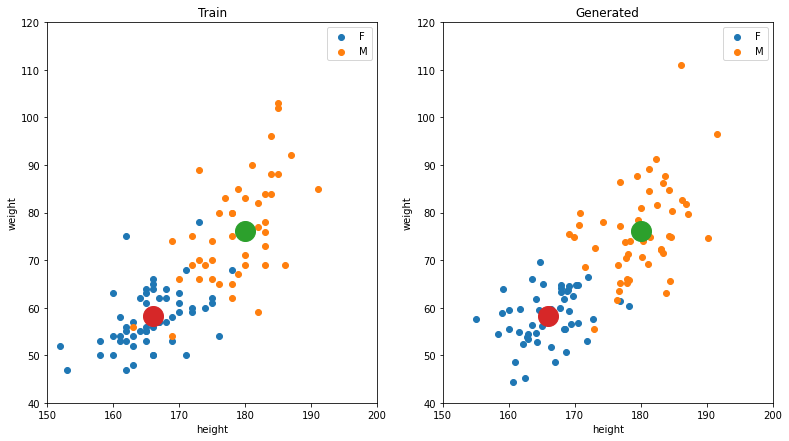

In [133]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(x=train_davis_df.where(train_davis_df["sex"] == "F")["height"],
              y=train_davis_df.where(train_davis_df["sex"] == "F")["weight"], label="F")
ax[0].scatter(x=train_davis_df.where(train_davis_df["sex"] == "M")["height"],
              y=train_davis_df.where(train_davis_df["sex"] == "M")["weight"], label="M")


ax[0].set_xlabel("height")
ax[0].set_ylabel("weight")
ax[0].set_title("Train")
ax[0].legend()
x_f = []
x_m = []
y_f = []
y_m = []
for i in range(len(generated_data)):
    if(generated_data[i][0] == 1):
        x_f.append(generated_data[i][1])
        y_f.append(generated_data[i][2])
    else:
        x_m.append(generated_data[i][1])
        y_m.append(generated_data[i][2])
                
        
        
ax[1].scatter(x=x_f, y=y_f, label="F")
ax[1].scatter(x=x_m, y=y_m, label="M")

man_mean_height = np.array(x_m).mean()
woman_mean_height = np.array(x_f).mean()
man_mean_weight = np.array(y_m).mean()
woman_mean_weight = np.array(y_f).mean()

ax[0].scatter(x=man_mean_height, y=man_mean_weight, s=400)
ax[0].scatter(x=woman_mean_height, y=woman_mean_weight, s=400)
ax[1].scatter(x=man_mean_height, y=man_mean_weight, s=400)
ax[1].scatter(x=woman_mean_height, y=woman_mean_weight, s=400)

ax[1].set_xlabel("height")
ax[1].set_ylabel("weight")
ax[1].set_title("Generated")
ax[1].legend()
plt.setp(ax, xlim=(150, 200), ylim=(40, 120))

# Задание 2

## a)Обучение линейной модели градиентным спуском

### Улучшение параметров (w1, b)

In [56]:
def param_upgrade(df, w1, b, alpha):
 
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    loss = y - w1 * x - b
    dQ_dw1 = -2 * x.dot(loss) / len(df.index)
    dQ_db = -2 * loss.mean() 
        
        
    w1 = w1 - alpha * dQ_dw1
    b = b - alpha * dQ_db
    return w1, b

In [57]:
param_upgrade(train_davis_df, 0, 0, 0.001)

(22.781080000000003, 0.13190000000000002)

### Подсчет среднеквадратической ошибки

In [58]:
def squared_error_loss(df, w1, b):
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    
    loss = y - w1 * x - b
    error = loss ** 2
    
    return error.mean()  

### Градиентный спуск

In [27]:
def gradient_descent(df, epoches_N, alpha):   
    w1 = -1
    b = -1
    w1_history = []
    b_history = []
    loss_history = []
    for i in range(epoches_N):
        w1, b = param_upgrade(df, w1, b, alpha)
        w1_history.append(w1)
        b_history.append(b)
        if i % 100 == 0:
            print(f"Loss in {i} epoch:" + str(squared_error_loss(df, w1, b)))
        loss_history.append(squared_error_loss(df, w1, b))
    return w1, b, w1_history, b_history, loss_history        

In [28]:
w1, b, w1_history, b_history, loss_history = gradient_descent(train_davis_df, 10000, 1e-3)

Loss in 0 epoch:191677980.08815184
Loss in 100 epoch:inf


<ipython-input-26-dbb66dd7cb54>:7: RuntimeWarning: overflow encountered in double_scalars
  error += (y[i] - w1 * x[i] - b) ** 2
<ipython-input-24-807c16274594>:10: RuntimeWarning: overflow encountered in double_scalars
  dQ_dw1 += (-2 * x[i] * (y[i] - w1 * x[i] - b) / N)
<ipython-input-24-807c16274594>:14: RuntimeWarning: invalid value encountered in double_scalars
  w1 = w1 - alpha * dQ_dw1


Loss in 200 epoch:nan
Loss in 300 epoch:nan
Loss in 400 epoch:nan
Loss in 500 epoch:nan
Loss in 600 epoch:nan
Loss in 700 epoch:nan
Loss in 800 epoch:nan
Loss in 900 epoch:nan
Loss in 1000 epoch:nan
Loss in 1100 epoch:nan
Loss in 1200 epoch:nan
Loss in 1300 epoch:nan
Loss in 1400 epoch:nan
Loss in 1500 epoch:nan
Loss in 1600 epoch:nan
Loss in 1700 epoch:nan
Loss in 1800 epoch:nan
Loss in 1900 epoch:nan
Loss in 2000 epoch:nan
Loss in 2100 epoch:nan
Loss in 2200 epoch:nan
Loss in 2300 epoch:nan
Loss in 2400 epoch:nan
Loss in 2500 epoch:nan
Loss in 2600 epoch:nan
Loss in 2700 epoch:nan
Loss in 2800 epoch:nan
Loss in 2900 epoch:nan
Loss in 3000 epoch:nan
Loss in 3100 epoch:nan
Loss in 3200 epoch:nan
Loss in 3300 epoch:nan
Loss in 3400 epoch:nan
Loss in 3500 epoch:nan
Loss in 3600 epoch:nan
Loss in 3700 epoch:nan
Loss in 3800 epoch:nan
Loss in 3900 epoch:nan
Loss in 4000 epoch:nan
Loss in 4100 epoch:nan
Loss in 4200 epoch:nan
Loss in 4300 epoch:nan
Loss in 4400 epoch:nan
Loss in 4500 epoch:

In [29]:
w1, b

(nan, nan)

In [30]:
for i in range(len(w1_history)):
    if i % 200 == 0:
        print(f"w1 in {i} epoch:" + str(w1_history[i]))

w1 in 0 epoch:81.04860000000002
w1 in 200 epoch:nan
w1 in 400 epoch:nan
w1 in 600 epoch:nan
w1 in 800 epoch:nan
w1 in 1000 epoch:nan
w1 in 1200 epoch:nan
w1 in 1400 epoch:nan
w1 in 1600 epoch:nan
w1 in 1800 epoch:nan
w1 in 2000 epoch:nan
w1 in 2200 epoch:nan
w1 in 2400 epoch:nan
w1 in 2600 epoch:nan
w1 in 2800 epoch:nan
w1 in 3000 epoch:nan
w1 in 3200 epoch:nan
w1 in 3400 epoch:nan
w1 in 3600 epoch:nan
w1 in 3800 epoch:nan
w1 in 4000 epoch:nan
w1 in 4200 epoch:nan
w1 in 4400 epoch:nan
w1 in 4600 epoch:nan
w1 in 4800 epoch:nan
w1 in 5000 epoch:nan
w1 in 5200 epoch:nan
w1 in 5400 epoch:nan
w1 in 5600 epoch:nan
w1 in 5800 epoch:nan
w1 in 6000 epoch:nan
w1 in 6200 epoch:nan
w1 in 6400 epoch:nan
w1 in 6600 epoch:nan
w1 in 6800 epoch:nan
w1 in 7000 epoch:nan
w1 in 7200 epoch:nan
w1 in 7400 epoch:nan
w1 in 7600 epoch:nan
w1 in 7800 epoch:nan
w1 in 8000 epoch:nan
w1 in 8200 epoch:nan
w1 in 8400 epoch:nan
w1 in 8600 epoch:nan
w1 in 8800 epoch:nan
w1 in 9000 epoch:nan
w1 in 9200 epoch:nan
w1 in 

In [31]:
for i in range(len(b_history)):
    if i % 200 == 0:
        print(f"w1 in {i} epoch:" + str(b_history[i]))

w1 in 0 epoch:-0.5232199999999998
w1 in 200 epoch:nan
w1 in 400 epoch:nan
w1 in 600 epoch:nan
w1 in 800 epoch:nan
w1 in 1000 epoch:nan
w1 in 1200 epoch:nan
w1 in 1400 epoch:nan
w1 in 1600 epoch:nan
w1 in 1800 epoch:nan
w1 in 2000 epoch:nan
w1 in 2200 epoch:nan
w1 in 2400 epoch:nan
w1 in 2600 epoch:nan
w1 in 2800 epoch:nan
w1 in 3000 epoch:nan
w1 in 3200 epoch:nan
w1 in 3400 epoch:nan
w1 in 3600 epoch:nan
w1 in 3800 epoch:nan
w1 in 4000 epoch:nan
w1 in 4200 epoch:nan
w1 in 4400 epoch:nan
w1 in 4600 epoch:nan
w1 in 4800 epoch:nan
w1 in 5000 epoch:nan
w1 in 5200 epoch:nan
w1 in 5400 epoch:nan
w1 in 5600 epoch:nan
w1 in 5800 epoch:nan
w1 in 6000 epoch:nan
w1 in 6200 epoch:nan
w1 in 6400 epoch:nan
w1 in 6600 epoch:nan
w1 in 6800 epoch:nan
w1 in 7000 epoch:nan
w1 in 7200 epoch:nan
w1 in 7400 epoch:nan
w1 in 7600 epoch:nan
w1 in 7800 epoch:nan
w1 in 8000 epoch:nan
w1 in 8200 epoch:nan
w1 in 8400 epoch:nan
w1 in 8600 epoch:nan
w1 in 8800 epoch:nan
w1 in 9000 epoch:nan
w1 in 9200 epoch:nan
w1 i

### Нормализируем данные

In [32]:
def normalize(df):
    df = df.copy()
    df["height"] = (df["height"] - df["height"].mean()) / df["height"].std()
    df["weight"] = (df["weight"] - df["weight"].mean()) / df["weight"].std() 
    return df 
normalize(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
149,150.0,M,1.721352,1.486833,86.0,183.0
139,140.0,M,1.487154,2.315482,83.0,188.0
96,97.0,M,2.892340,1.605212,101.0,182.0
31,32.0,M,0.706496,0.776563,73.0,175.0
177,178.0,M,0.003903,-0.170465,67.0,165.0
...,...,...,...,...,...,...
88,89.0,F,-0.698689,-0.999114,59.0,160.0
27,28.0,F,-0.620623,-0.643979,60.0,160.0
154,155.0,F,-1.401282,-0.999114,44.0,160.0
19,20.0,F,-0.386426,0.421427,61.0,171.0


In [33]:
w1, b, w1_history, b_history, loss_history = gradient_descent(normalize(train_davis_df), 10000, 0.001)

Loss in 0 epoch:4.517399381133555
Loss in 100 epoch:3.160814028049184
Loss in 200 epoch:2.24906565692737
Loss in 300 epoch:1.6362862718792102
Loss in 400 epoch:1.2244405375673348
Loss in 500 epoch:0.9476404198355334
Loss in 600 epoch:0.7616034578101117
Loss in 700 epoch:0.6365679176432382
Loss in 800 epoch:0.5525312205146236
Loss in 900 epoch:0.4960497834971545
Loss in 1000 epoch:0.4580882489821607
Loss in 1100 epoch:0.43257398537749575
Loss in 1200 epoch:0.4154255867320999
Loss in 1300 epoch:0.4038999386474009
Loss in 1400 epoch:0.3961533875857291
Loss in 1500 epoch:0.3909468061347674
Loss in 1600 epoch:0.3874473690559555
Loss in 1700 epoch:0.3850953277079963
Loss in 1800 epoch:0.38351446937322387
Loss in 1900 epoch:0.38245193695400787
Loss in 2000 epoch:0.3817377816615585
Loss in 2100 epoch:0.381257778212241
Loss in 2200 epoch:0.3809351537565604
Loss in 2300 epoch:0.38071830774624976
Loss in 2400 epoch:0.380572558334918
Loss in 2500 epoch:0.38047459503591896
Loss in 2600 epoch:0.3804

In [34]:
w1, b

(0.784783462199989, -2.0202865397415327e-09)

In [35]:
for i in range(len(w1_history)):
    if i % 200 == 0:
        print(f"w1 in {i} epoch:" + str(w1_history[i]))

w1 in 0 epoch:-0.9964661287361204
w1 in 200 epoch:-0.4135389344913559
w1 in 400 epoch:-0.021379005361303046
w1 in 600 epoch:0.24244366672133397
w1 in 800 epoch:0.41992840479547894
w1 in 1000 epoch:0.5393299406853925
w1 in 1200 epoch:0.6196564348254937
w1 in 1400 epoch:0.6736954856027698
w1 in 1600 epoch:0.7100498546085391
w1 in 1800 epoch:0.7345069856424434
w1 in 2000 epoch:0.7509603384241849
w1 in 2200 epoch:0.7620292089873423
w1 in 2400 epoch:0.7694757092337776
w1 in 2600 epoch:0.7744852868238103
w1 in 2800 epoch:0.7778554428434208
w1 in 3000 epoch:0.7801226902095693
w1 in 3200 epoch:0.7816479639919686
w1 in 3400 epoch:0.7826740805710466
w1 in 3600 epoch:0.7833643928585895
w1 in 3800 epoch:0.7838287953095872
w1 in 4000 epoch:0.7841412186002977
w1 in 4200 epoch:0.7843513990426472
w1 in 4400 epoch:0.7844927963701183
w1 in 4600 epoch:0.7845879203692518
w1 in 4800 epoch:0.7846519143313242
w1 in 5000 epoch:0.784694965792772
w1 in 5200 epoch:0.7847239283428762
w1 in 5400 epoch:0.7847434126

In [36]:
for i in range(len(b_history)):
    if i % 200 == 0:
        print(f"b in {i} epoch:" + str(b_history[i]))

b in 0 epoch:-0.998
b in 200 epoch:-0.6687115105103475
b in 400 epoch:-0.4480712267425152
b in 600 epoch:-0.3002308485483082
b in 800 epoch:-0.20117016456366993
b in 1000 epoch:-0.13479439340179047
b in 1200 epoch:-0.09031920082168081
b in 1400 epoch:-0.06051852626207785
b in 1600 epoch:-0.04055053618294023
b in 1800 epoch:-0.027170952207313196
b in 2000 epoch:-0.018205940373303618
b in 2200 epoch:-0.01219891972674682
b in 2400 epoch:-0.008173905848765008
b in 2600 epoch:-0.005476938804506168
b in 2800 epoch:-0.003669831684302809
b in 3000 epoch:-0.002458976642213437
b in 3200 epoch:-0.0016476412672588722
b in 3400 epoch:-0.0011040046899879862
b in 3600 epoch:-0.0007397401241007246
b in 3800 epoch:-0.0004956640639004556
b in 4000 epoch:-0.00033212050588849753
b in 4200 epoch:-0.00022253788092615792
b in 4400 epoch:-0.0001491118662325163
b in 4600 epoch:-9.991264659670308e-05
b in 4800 epoch:-6.694663008508657e-05
b in 5000 epoch:-4.485769752296924e-05
b in 5200 epoch:-3.005697261397902

In [37]:
for i in range(len(loss_history)):
    if i % 200 == 0:
        print(f"loss in {i} epoch:" + str(loss_history[i]))

loss in 0 epoch:4.517399381133555
loss in 200 epoch:2.24906565692737
loss in 400 epoch:1.2244405375673348
loss in 600 epoch:0.7616034578101117
loss in 800 epoch:0.5525312205146236
loss in 1000 epoch:0.4580882489821607
loss in 1200 epoch:0.4154255867320999
loss in 1400 epoch:0.3961533875857291
loss in 1600 epoch:0.3874473690559555
loss in 1800 epoch:0.38351446937322387
loss in 2000 epoch:0.3817377816615585
loss in 2200 epoch:0.3809351537565604
loss in 2400 epoch:0.380572558334918
loss in 2600 epoch:0.3804087502771123
loss in 2800 epoch:0.3803347466394005
loss in 3000 epoch:0.380301313611066
loss in 3200 epoch:0.38028620922131007
loss in 3400 epoch:0.3802793852773936
loss in 3600 epoch:0.3802763022847374
loss in 3800 epoch:0.3802749094028642
loss in 4000 epoch:0.3802742800983952
loss in 4200 epoch:0.38027399577535304
loss in 4400 epoch:0.3802738673153319
loss in 4600 epoch:0.38027380927517335
loss in 4800 epoch:0.38027378305148113
loss in 5000 epoch:0.380273771202972
loss in 5200 epoch:0

In [38]:
def predict(x, w1, b):
    return w1 * x + b

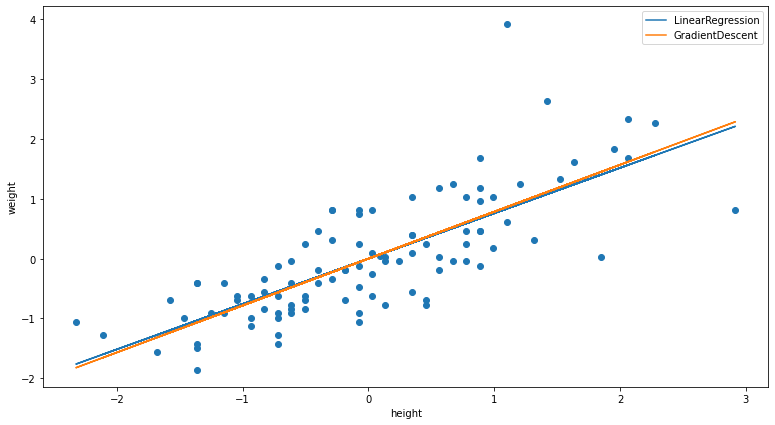

In [39]:
norm_test_df = normalize(test_davis_df)
linear_regression = LinearRegression()
x = norm_test_df["height"]
y = norm_test_df["weight"]
linear_regression.fit(x.values.reshape(-1, 1), y)
plt.plot(x, linear_regression.predict(x.values.reshape(-1, 1)), label="LinearRegression")
plt.scatter(x, y)
plt.plot(x, predict(x, w1, b), label="GradientDescent")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

In [40]:
w1, b

(0.784783462199989, -2.0202865397415327e-09)

In [41]:
print(linear_regression.coef_)
print(linear_regression.intercept_)

[0.75861869]
-3.309236531568952e-16


### Визуализация

Text(0, 0.5, 'w1')

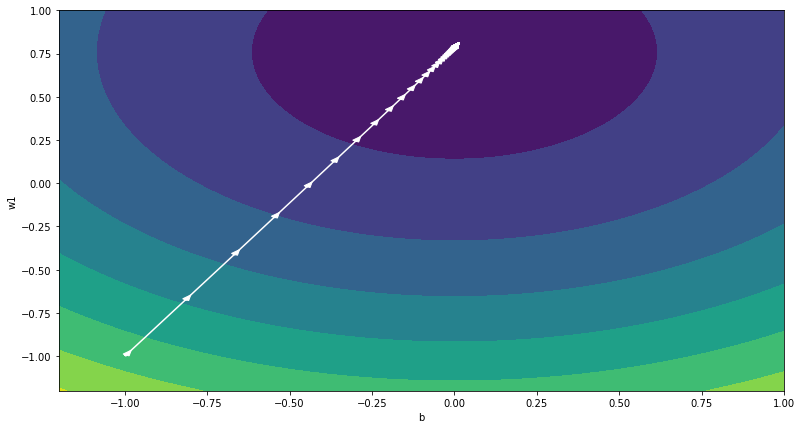

In [42]:
x = np.linspace(-1.2, 1, 100)
y = np.linspace(-1.2, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(shape=(x.size, y.size))
for i in range(len(x)):
    for j in range(len(y)):
        loss = squared_error_loss(norm_test_df, x[i], y[j])
        Z[i, j] = loss
plt.contourf(X, Y, Z)
plt.plot(b_history, w1_history, color="WHITE")
for i in range(len(b_history)):
    if i % 100 == 0:
        plt.arrow(b_history[i], w1_history[i], b_history[i + 1] - b_history[i], w1_history[i + 1] - w1_history[i],
                  width=0.007, color="WHITE")
plt.xlabel("b")
plt.ylabel("w1")

## б)Обучение линейной модели градиентным спуском

In [43]:
def sex_converter(df):
    converted_df = df.copy()
    converted_df["sex"] = (converted_df["sex"] == "M").values.astype(int)
    return converted_df

In [44]:
sex_converter(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
149,150.0,1,88.0,184.0,86.0,183.0
139,140.0,1,85.0,191.0,83.0,188.0
96,97.0,1,103.0,185.0,101.0,182.0
31,32.0,1,75.0,178.0,73.0,175.0
177,178.0,1,66.0,170.0,67.0,165.0
...,...,...,...,...,...,...
88,89.0,0,57.0,163.0,59.0,160.0
27,28.0,0,58.0,166.0,60.0,160.0
154,155.0,0,48.0,163.0,44.0,160.0
19,20.0,0,61.0,175.0,61.0,171.0


In [45]:
def param_upgrade(df, w1, w2, b, alpha):
    df = sex_converter(df)
    x1 = df["height"].to_numpy()
    x2 = df["sex"].to_numpy()
    y = df["weight"].to_numpy()
    
    loss = y - w1 * x1 - w2 * x2 - b
    dQ_dw1 = -2 * x1.dot(loss) / len(df.index)
    dQ_dw2 = -2 * x2.dot(loss) / len(df.index)
    dQ_db = -2 * loss.mean()
    
        
    w1 = w1 - alpha * dQ_dw1
    w2 = w2 - alpha * dQ_dw2
    b = b - alpha * dQ_db
    return w1, w2, b

### Подсчет среднеквадратической ошибки

In [46]:
def squared_error_loss(df, w1, w2, b):
    df = sex_converter(df)
    x1 = df["height"].to_numpy()
    x2 = df["sex"].to_numpy()
    y = df["weight"].to_numpy()
    
    loss = y - w1 * x1 - w2 * x2 - b
    error = loss ** 2

    return error.mean()  

In [47]:
def predict(x1, x2, w1, w2, b):
    return w1 * x1 + w2 * x2 + b;

In [48]:
def gradient_descent_2(df, epoches_N, alpha):   
    w1 = -1
    w2 = -1
    b = -1
    w1_history = []
    w2_history = []
    b_history = []
    loss_history = []
    for i in range(epoches_N):
        w1, w2, b = param_upgrade(df, w1, w2, b, alpha)
        w1_history.append(w1)
        w2_history.append(w2)
        b_history.append(b)
        if i % 200 == 0:
            print(f"Loss in {i} epoch:" + str(squared_error_loss(df, w1, w2, b)))
        loss_history.append(squared_error_loss(df, w1, w2, b))
    return w1, w2, b, w1_history, w2_history, b_history, loss_history        

In [49]:
w1, w2, b, w1_history, w2_history, b_history, loss_history = gradient_descent_2(normalize(train_davis_df), 10000, 0.001)

Loss in 0 epoch:7.285832755559296
Loss in 200 epoch:2.7488227650123576
Loss in 400 epoch:1.1906903742355044
Loss in 600 epoch:0.651661927379331
Loss in 800 epoch:0.46327079502869056
Loss in 1000 epoch:0.39641456519568385
Loss in 1200 epoch:0.37208723747127365
Loss in 1400 epoch:0.36282801162545253
Loss in 1600 epoch:0.3589968042555149
Loss in 1800 epoch:0.3571674060539858
Loss in 2000 epoch:0.3561034544953302
Loss in 2200 epoch:0.3553504037197008
Loss in 2400 epoch:0.354737195711963
Loss in 2600 epoch:0.35419744281479626
Loss in 2800 epoch:0.3537042114984175
Loss in 3000 epoch:0.3532457924656906
Loss in 3200 epoch:0.35281651231547867
Loss in 3400 epoch:0.35241317209859346
Loss in 3600 epoch:0.3520336350110101
Loss in 3800 epoch:0.3516762528892802
Loss in 4000 epoch:0.3513396272728265
Loss in 4200 epoch:0.35102250675597896
Loss in 4400 epoch:0.3507237409892971
Loss in 4600 epoch:0.3504422586937367
Loss in 4800 epoch:0.3501770560661901
Loss in 5000 epoch:0.34992718979730575
Loss in 5200 

In [50]:
w1, w2, b

(0.6013693457193918, 0.48752477189648824, -0.2111843151941672)

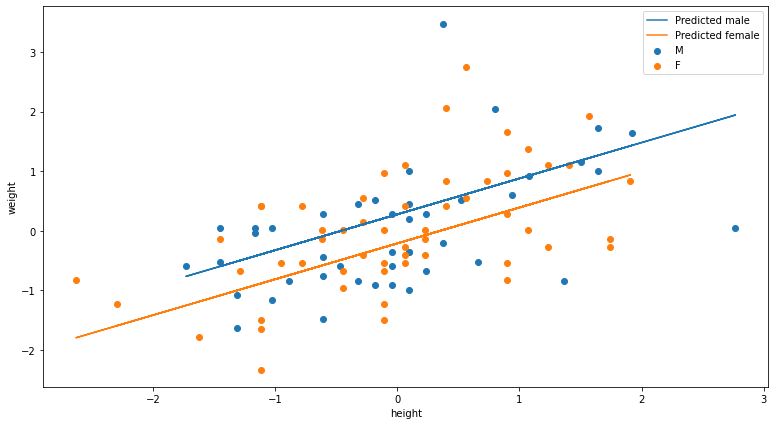

In [51]:
norm_test_df_male = normalize(test_davis_df[test_davis_df["sex"] == "M"])
norm_test_df_female = normalize(test_davis_df[test_davis_df["sex"] == "F"])
x1_male = norm_test_df_male["height"]
x1_female = norm_test_df_female["height"]
x2_male = 1
x2_female = 0
y_male = norm_test_df_male["weight"]
y_female = norm_test_df_female["weight"]
plt.scatter(x1_male, y_male, label="M")
plt.scatter(x1_female, y_female, label="F")
plt.plot(x1_male, predict(x1_male, x2_male, w1, w2, b), label="Predicted male")
plt.plot(x1_female, predict(x1_female, x2_female, w1, w2, b), label="Predicted female")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()